# Introduction to Deep Learning -  Sign language digits recognition
This is notebook is an attempt at creating a neural network capable of differentiating between sign language digits
## 1. Setup
Firstly imports needed for the project as well as some aesthetic touches to the future plots.

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True, figsize=(12, 6))
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10,
       grid=True)
plt.rc('grid', alpha=1)

## 2. Deleting corrupted files
To filter badly-encoded images the first 10 bytes of each file were checked to see if they contain a string "JFIF" (but in byte format, not unicode). Lack of such string might indicate that the file is corrupted as all ".JPG" files should have such string (in byte format) at the beginning of the file.

In [2]:
num_skipped = 0
folder_names = [f"{i}" for i in range(10)]
files_to_delete = []
count = 0
for folder_name in folder_names:
       folder_path = os.path.join("data/dataset", folder_name)
       for file_name in os.listdir(folder_path):
              file_path = os.path.join(folder_path, file_name)
              try:
                     file_obj = open(file_path, "rb")
                     is_jfif = tf.compat.as_bytes("JFIF") in file_obj.peek(10)
                     count += 1
              finally:
                     file_obj.close()

              if not is_jfif:
                     num_skipped += 1
                     files_to_delete.append(file_path)
                     # os.remove(file_path)
print(f"{num_skipped} files to delete out of {count} files")
print(files_to_delete)

3 files to delete out of 2062 files
['data/dataset/7/IMG_5874.JPG', 'data/dataset/7/IMG_5935.JPG', 'data/dataset/7/IMG_5978.JPG']


## 3. Data preprocessing
Data is split into three chunks. This is because a lot of data is needed for training, some data is needed for validation of said training, on per epoch basis, and finally some data is needed for final evaluation of the model after all the training is done and all parameters are picked.

It was decided that 70% of the data will be used for training and the rest will be split in a 2:1 ratio between validation data and training data. Because the data set is quite small (only 2062 observations) it is advised to avoid dividing the dataset in a way which would result in a small validation dataset. Using a small validation dataset creates noise in validation accuracy and loss calculations while training.

In [3]:
image_size = (100, 100)
batch_size = 32

train_ds = image_dataset_from_directory(
       'data/dataset',
       validation_split=0.3,
       subset='training',
       seed=1337,
       image_size=image_size,
       batch_size=batch_size,
       labels="inferred",
       label_mode="categorical",
)

val_ds = image_dataset_from_directory(
       'data/dataset',
       validation_split=0.3,
       subset='validation',
       seed=1337,
       image_size=image_size,
       batch_size=batch_size,
       labels="inferred",
       label_mode="categorical",
)

val_ds_size = len(val_ds)
test_ds_size = val_ds_size // 3
test_ds = val_ds.take(test_ds_size)
val_ds = val_ds.skip(test_ds_size)

Found 2062 files belonging to 10 classes.
Using 1444 files for training.
Found 2062 files belonging to 10 classes.
Using 618 files for validation.


2022-01-17 19:05:23.466621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 19:05:23.471880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 19:05:23.472071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 19:05:23.472684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

A sample of the data can be seen below.

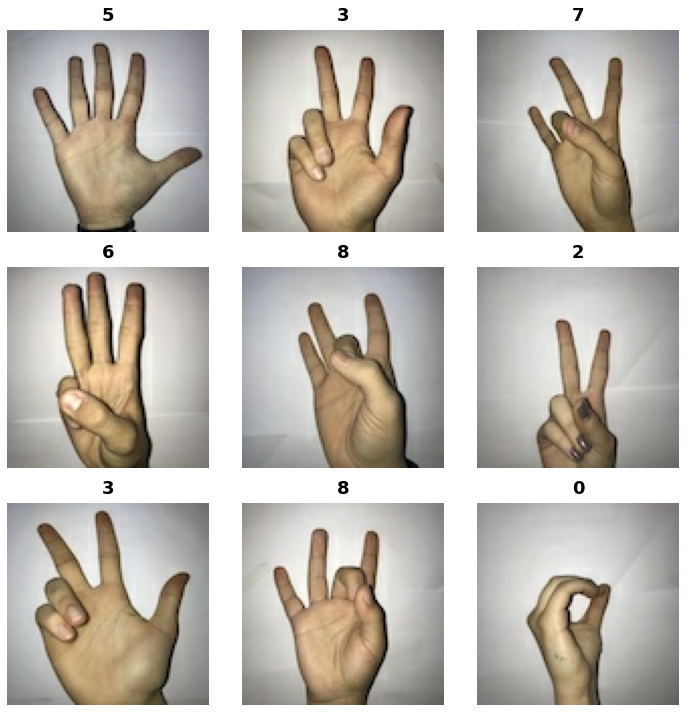

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
       labels_tensor = tf.argmax(labels, axis=1)
       for i in range(9):
              ax = plt.subplot(3, 3, i + 1)
              plt.title(int(labels_tensor[i]))
              plt.imshow(images[i].numpy().astype('uint8'))
              plt.axis("off")

For the model to learn to recognize the actual sign language digits some randomness needs to be implemented. Without it the model might simply learn to recognize specific way of showing a digit. The data was collected in such a way that the hands base is in the bottom halve of the image and fingers are in the top halve. Further more all (or almost all) images contain someones right hand. This is not how digits are shown in real world. Someone might use his or her left hand or maybe with a hand rotated 90 degrees  slight rotation. Augmenting the images also has the added benefit or artificialy creating new data points virtually expanding the data.

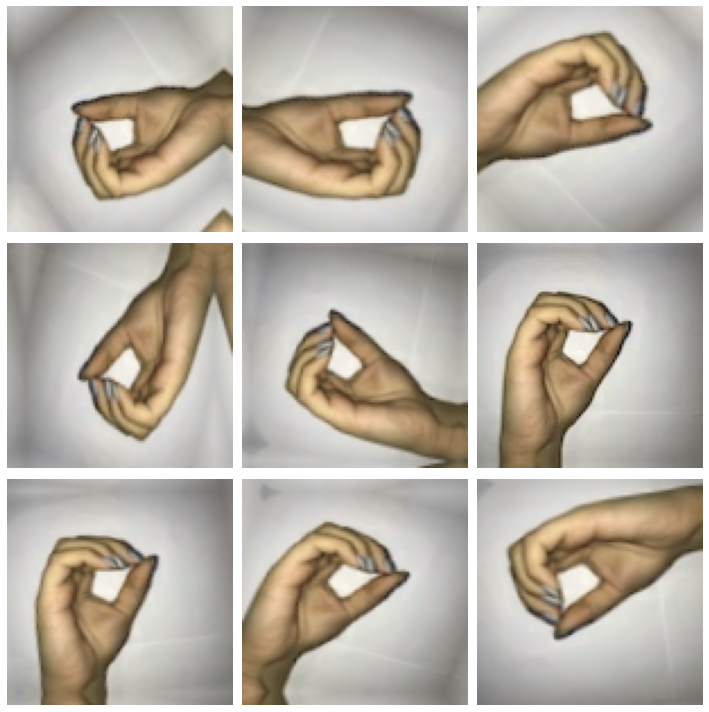

In [5]:
data_augmentation = models.Sequential(
       [
              layers.RandomFlip("horizontal"),
              layers.RandomFlip("vertical"),
              layers.RandomRotation(0.3),
              layers.RandomZoom(-0.2, 0.2),
       ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
       for i in range(9):
              augmented_images = data_augmentation(images)
              ax = plt.subplot(3, 3, i + 1)
              plt.imshow(augmented_images[0].numpy().astype("uint8"))
              plt.axis("off")

In [6]:
# Adding buffer for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## 4. Creating the model
Since this is this authors first attempt at deep learning two models were used. First model was built from scratch. Second one is a smaller version of Xception model and is used for comparison of performance, to see what results could have been achieved.

 The model below was mostly created by trail and error. While experimenting it was apparent that shallow CNN doesn't have enough capacity and field of view to recognize the features properly, achieving validation accuracy of around 50%. After some testing five hidden layers seemed enough for the model to learn, even with only 16 nodes per layer, but it would learn rather slowly, and had a tendency to underfit. Further more it was noted that increasing the size of the layer before the fully-connected layer responsible for categorizing the data would correlate quite well with increase in accuracy.

Finally a tree-like structure seen below has been the best attempt. Each layer increases it's nodes field of view by two. Last hidden layer is a flat 1x1x1024 tensor which is fully connected to a softmax dense layer.

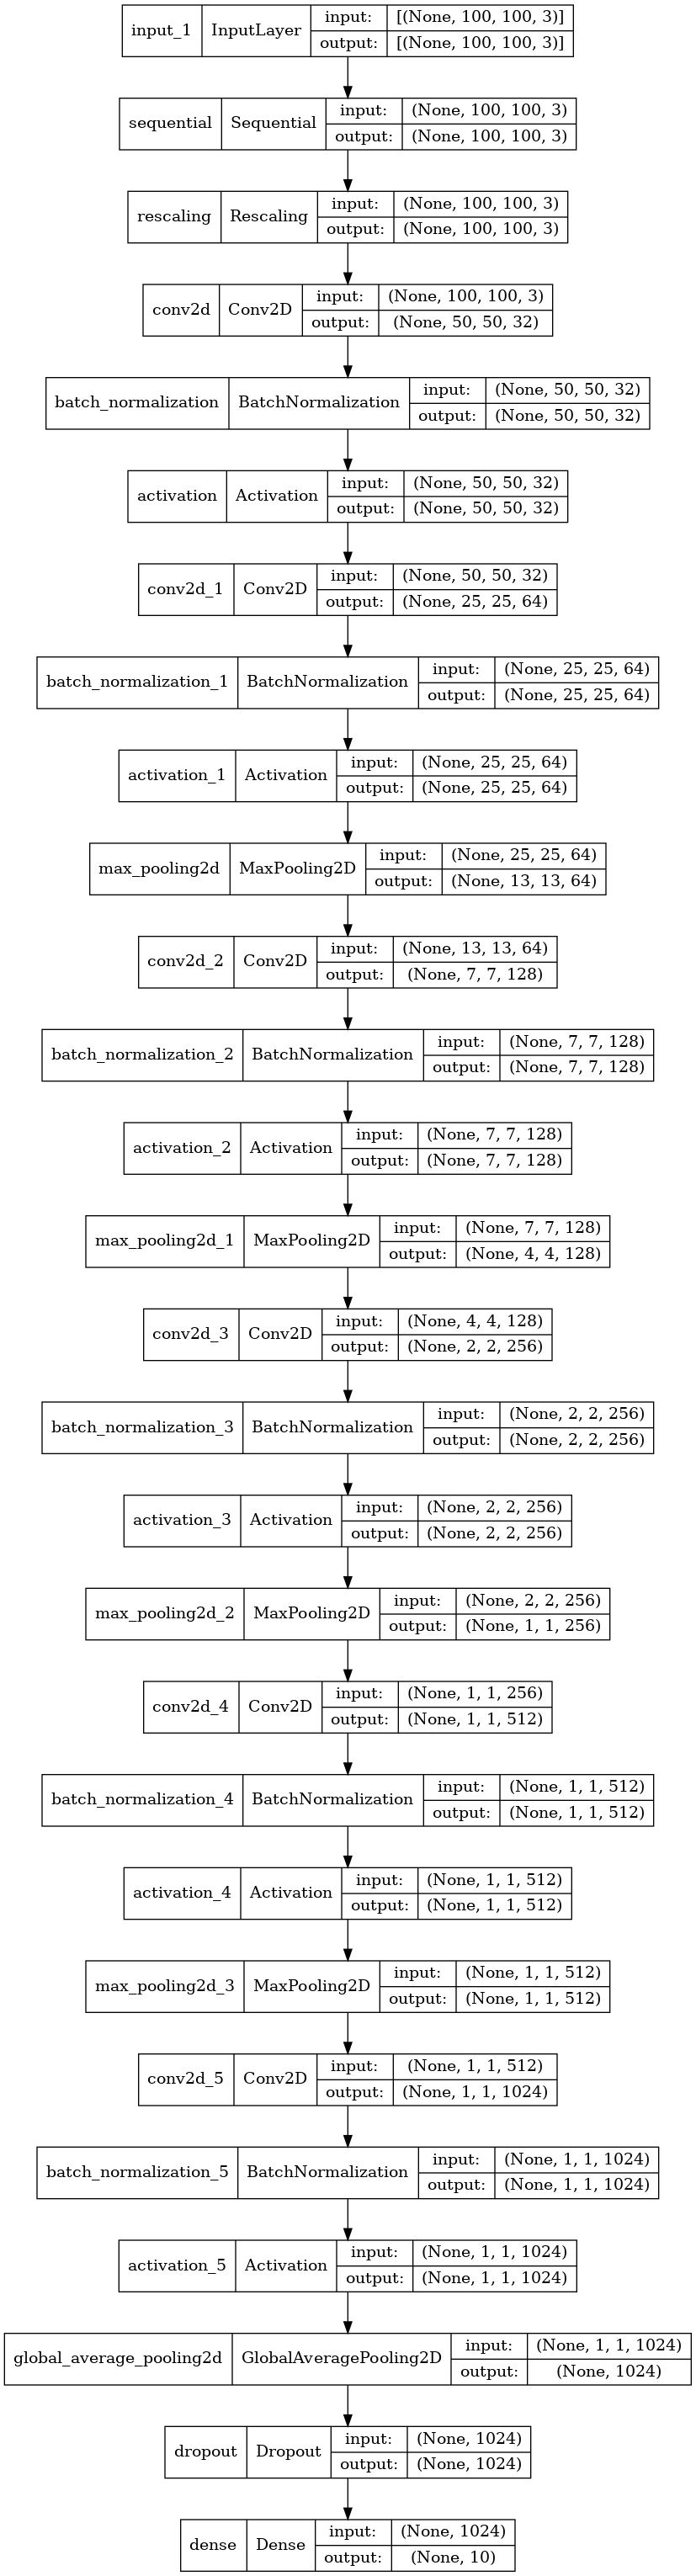

In [7]:
def make_own_model(input_shape):
       inputs = keras.Input(shape=input_shape)
       # Image augmentation block
       x = data_augmentation(inputs)

       # Entry block
       x = layers.Rescaling(1.0 / 255)(x)
       x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)
       x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

       x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)
       x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

       x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)
       x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

       x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)
       x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

       x = layers.Conv2D(1024, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.GlobalAveragePooling2D()(x)
       x = layers.Dropout(0.5)(x)

       outputs = layers.Dense(10, activation="softmax")(x)

       return keras.Model(inputs, outputs)


own_model = make_own_model(input_shape=image_size + (3,))
keras.utils.plot_model(own_model, show_shapes=True, to_file="own_model.png")

Early stopping was used in case the model starts to deteriorate.

In [8]:
def train_model(model):
      epochs = 1000

      callbacks = [
              keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=epochs // 5,
                                            verbose=1,
                                            min_delta=0.01,
                                           restore_best_weights=True)
       ]
      model.compile(
              optimizer=keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"],
      )

      return model.fit(
              train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
      )


def plot_model_performance(history):
       loss = history.history['loss']
       accuracy = history.history['accuracy']
       val_loss = history.history['val_loss']
       val_accuracy = history.history['val_accuracy']
       x_axis = [i for i in range(len(loss))]


       fig, sub = plt.subplots(1, 2)
       sub[0].plot(x_axis, loss, 'y', label="Training loss")
       sub[0].plot(x_axis, val_loss, 'b', label="Validation loss")
       sub[0].set_title("Training and validation loss")
       sub[0].set_xlabel("Epochs")
       sub[0].set_ylabel("Loss")
       sub[0].legend()

       sub[1].plot(x_axis, accuracy, 'y', label="Training accuracy")
       sub[1].plot(x_axis, val_accuracy, 'b', label="Validation accuracy")
       sub[1].set_title("Training and validation accuracy")
       sub[1].set_xlabel("Epochs")
       sub[1].set_ylabel("Loss")
       sub[1].legend()

In [9]:
own_history = train_model(own_model)

Epoch 1/1000


2022-01-17 19:05:27.305910: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-01-17 19:05:27.767298: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/46 [..............................] - ETA: 1:54 - loss: 3.1889 - accuracy: 0.0625

2022-01-17 19:05:28.296259: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


46/46 [==============================] - 3s 18ms/step - loss: 2.8403 - accuracy: 0.1427 - val_loss: 2.3036 - val_accuracy: 0.1033
Epoch 2/1000
46/46 [==============================] - 1s 12ms/step - loss: 2.3743 - accuracy: 0.2417 - val_loss: 2.3067 - val_accuracy: 0.0915
Epoch 3/1000
46/46 [==============================] - 1s 12ms/step - loss: 2.2297 - accuracy: 0.2819 - val_loss: 2.3166 - val_accuracy: 0.0775
Epoch 4/1000
46/46 [==============================] - 1s 11ms/step - loss: 2.0562 - accuracy: 0.3130 - val_loss: 2.3474 - val_accuracy: 0.0869
Epoch 5/1000
46/46 [==============================] - 1s 12ms/step - loss: 1.9847 - accuracy: 0.3303 - val_loss: 2.4704 - val_accuracy: 0.0822
Epoch 6/1000
46/46 [==============================] - 1s 11ms/step - loss: 1.8593 - accuracy: 0.3726 - val_loss: 2.6578 - val_accuracy: 0.0986
Epoch 7/1000
46/46 [==============================] - 1s 12ms/step - loss: 1.7420 - accuracy: 0.4107 - val_loss: 3.0792 - val_accuracy: 0.0962
Epoch 8/1000

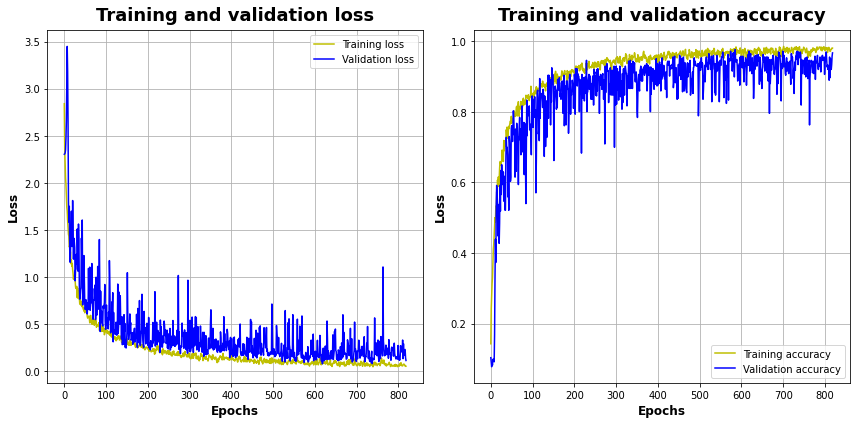

In [10]:
plot_model_performance(own_history)

In [11]:
own_model.evaluate(test_ds)

6/6 [==============================] - 0s 6ms/step - loss: 0.1347 - accuracy: 0.9531


[0.13474074006080627, 0.953125]

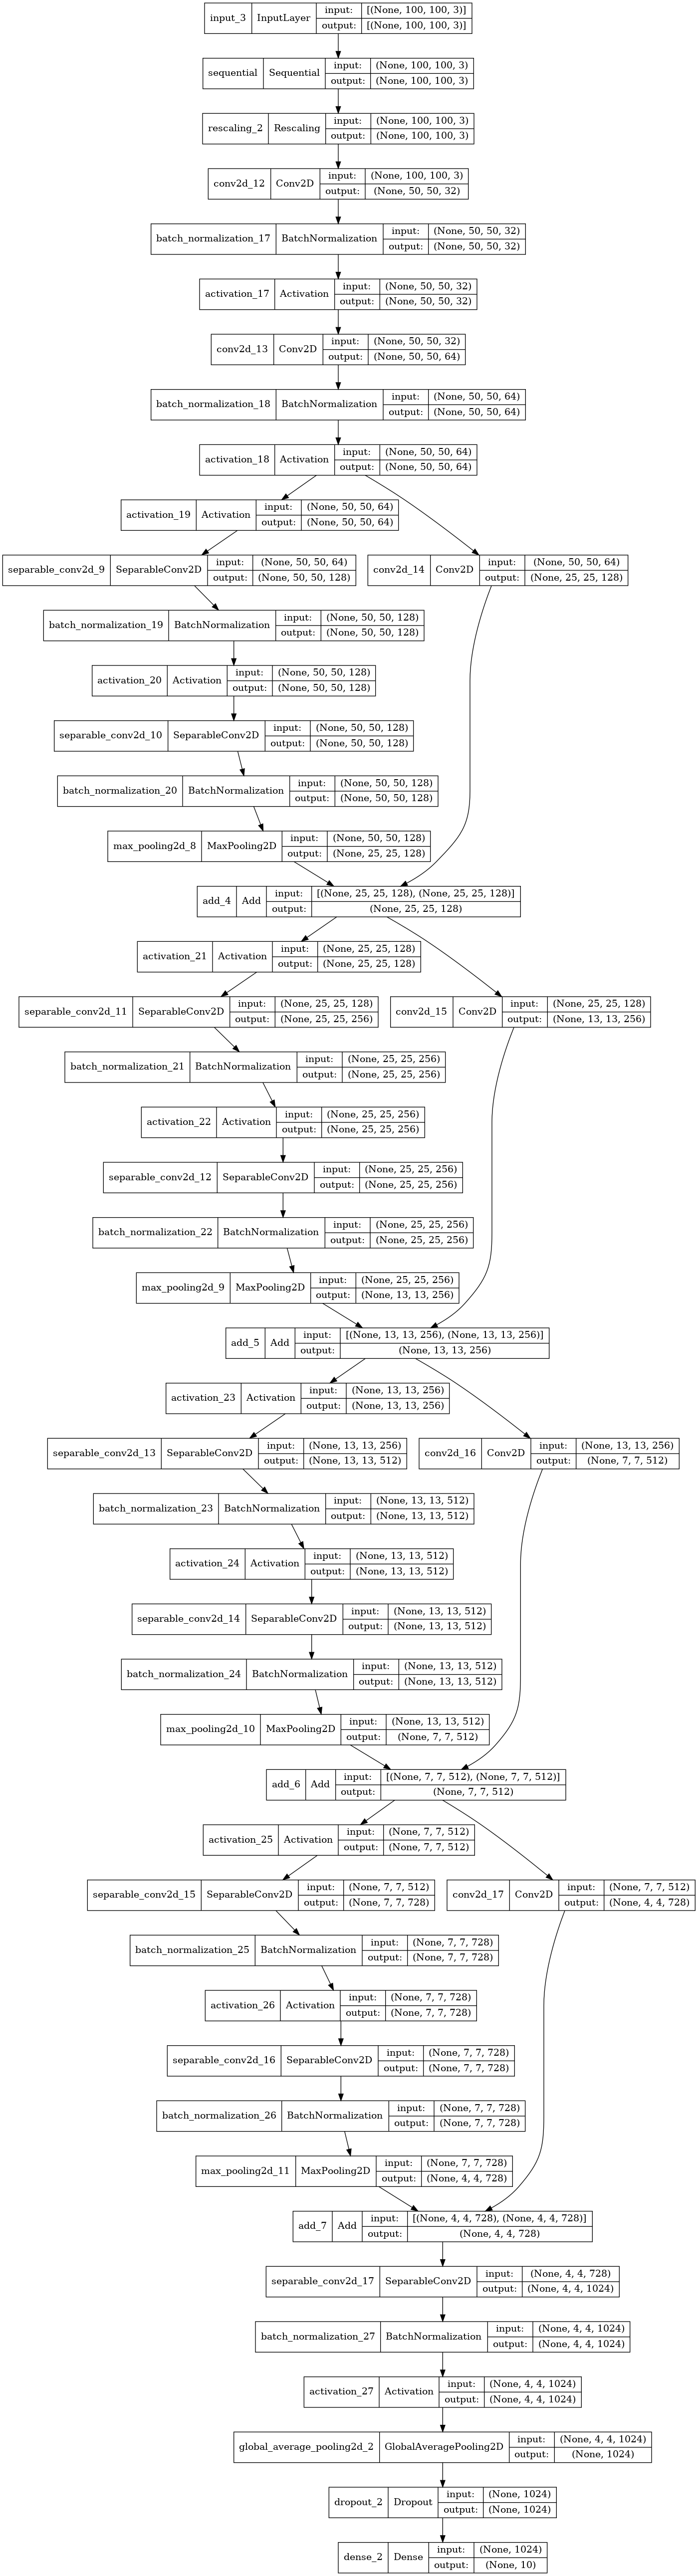

In [13]:
def make_xception_model(input_shape):
       inputs = keras.Input(shape=input_shape)
       # Image augmentation block
       x = data_augmentation(inputs)

       # Entry block
       x = layers.Rescaling(1.0 / 255)(x)
       x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.Conv2D(64, 3, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       previous_block_activation = x  # Set aside residual

       for size in [128, 256, 512, 728]:
              x = layers.Activation("relu")(x)
              x = layers.SeparableConv2D(size, 3, padding="same")(x)
              x = layers.BatchNormalization()(x)

              x = layers.Activation("relu")(x)
              x = layers.SeparableConv2D(size, 3, padding="same")(x)
              x = layers.BatchNormalization()(x)

              x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

              # Project residual
              residual = layers.Conv2D(size, 1, strides=2, padding="same")(
                     previous_block_activation
              )
              x = layers.add([x, residual])  # Add back residual
              previous_block_activation = x  # Set aside next residual

       x = layers.SeparableConv2D(1024, 3, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.GlobalAveragePooling2D()(x)


       x = layers.Dropout(0.5)(x)
       outputs = layers.Dense(10, activation="softmax")(x)
       return keras.Model(inputs, outputs)


xception_model = make_xception_model(input_shape=image_size + (3,))
keras.utils.plot_model(xception_model, show_shapes=True, to_file="xception_model.png")

In [14]:
xception_history = train_model(xception_model)

Epoch 1/1000
46/46 [==============================] - 4s 50ms/step - loss: 2.3677 - accuracy: 0.1267 - val_loss: 2.3024 - val_accuracy: 0.1009
Epoch 2/1000
46/46 [==============================] - 2s 37ms/step - loss: 2.1149 - accuracy: 0.2147 - val_loss: 2.3028 - val_accuracy: 0.1103
Epoch 3/1000
46/46 [==============================] - 2s 38ms/step - loss: 1.8830 - accuracy: 0.2992 - val_loss: 2.3017 - val_accuracy: 0.1103
Epoch 4/1000
46/46 [==============================] - 2s 39ms/step - loss: 1.6462 - accuracy: 0.4162 - val_loss: 2.3038 - val_accuracy: 0.1033
Epoch 5/1000
46/46 [==============================] - 2s 43ms/step - loss: 1.5171 - accuracy: 0.4578 - val_loss: 2.3085 - val_accuracy: 0.1080
Epoch 6/1000
46/46 [==============================] - 2s 42ms/step - loss: 1.4141 - accuracy: 0.4986 - val_loss: 2.3310 - val_accuracy: 0.1056
Epoch 7/1000
46/46 [==============================] - 2s 41ms/step - loss: 1.2369 - accuracy: 0.5630 - val_loss: 2.3425 - val_accuracy: 0.0986

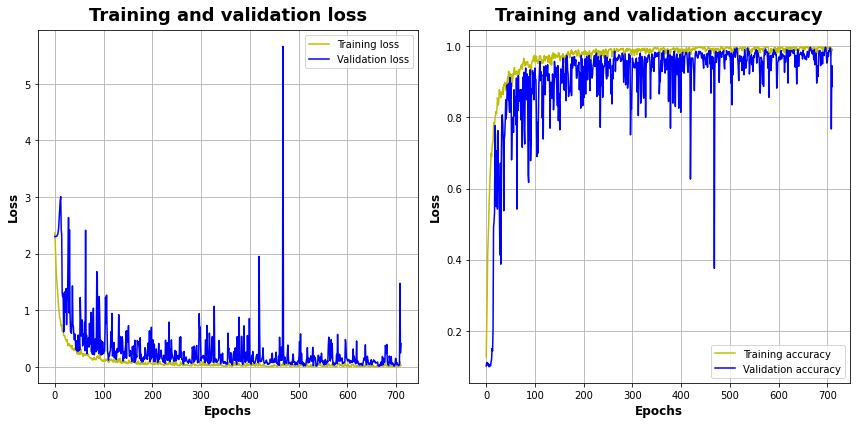

In [15]:
plot_model_performance(xception_history)

In [16]:
xception_model.evaluate(test_ds)

6/6 [==============================] - 0s 8ms/step - loss: 0.0564 - accuracy: 0.9844


[0.05638231709599495, 0.984375]

## 6. Conclusions
The new model performed better then it was expected. The results were close to those of Xceptions whichs is a sofisticated model created by a group of Deep Learning engineers and scientists.